In [126]:
import math
import zipfile
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
sns.set(style="darkgrid")

# Caracterização, limpeza e transformação de dados

Considerando o conjunto de dados do desafio "Spaceship Titanic" do Kaggle (https://www.kaggle.com/competitions/spaceship-titanic) e usando as bibliotecas Pandas, NumPy e SKLearn, e o Google Colab, faça:

1) Construa um notebook para com uma análise descritiva do dataset.

     a) Identifique os tipos de atributos (contínuos , discretos, binários (simétricos e assimétricos), nominais e ordinais).

     b) Para atributo numérico, identifique qual o seu intervalo de valores, valor médio, máximo, mínimo e desvio-padrão. Faça gráficos que permitam visualizar a distribuição dos valores.

     c) Para os atributos binários, nominais e ordinais, quais os valores possíveis e a popularidade de cada.

     d) Identifique os valores ausentes, aberrantes e inconsistências.

     e) Verifique como é a correlação entre os atributos.

2) A limpeza de dados e transformação. Lembre-se de aprender como fazer a limpeza e transformação no conjunto de dados de treinamento e aplicar o que foi aprendido nos conjuntos de dados de treinamento e teste.

     a) Preencha os valores ausentes (Tente atribuir o valor mais provável).

     b) Suavize os ruídos (use o qcut ou cut para dividir os bins).

     c) Resolva as inconsistências, se houver.

     d) Transforme atributos categóricos nominais em um vetor numérico (por exemplo, usando o OneHotEncoder).

     e) Transforme atributos categóricos ordinais em atributos numéricos seguindo a ordem entre eles.

     f) Normalize os valores de atributos numéricos.

# Leitura dos dados

In [127]:
!git clone https://github.com/gabrielxcosta/PCC142---Data-Mining.git

fatal: destination path 'PCC142---Data-Mining' already exists and is not an empty directory.


In [128]:
path = '/content/PCC142---Data-Mining/spaceship_titanic/data.zip'

with zipfile.ZipFile(path, 'r') as zip_ref:
    print("Arquivos no zip:", zip_ref.namelist())

    # Conjunto de dados de treino, com os exemplos que têm o rótulo verdadeiro (Transported)
    with zip_ref.open('train.csv') as train_file:
        df_train = pd.read_csv(train_file)

    # Conjunto de dados de teste — as mesmas colunas que o train.csv, exceto pela coluna Transported, que é o que queremos prever
    with zip_ref.open('test.csv') as test_file:
        df_test = pd.read_csv(test_file)

    # Um exemplo de como deve ser formatado o seu arquivo final para submissão no Kaggle
    with zip_ref.open('sample_submission.csv') as sub_file:
        df_submission = pd.read_csv(sub_file)

df_tr = df_train.copy()
df_ts = df_test.copy()

Arquivos no zip: ['sample_submission.csv', 'test.csv', 'train.csv']


In [129]:
df_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [130]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [131]:
df_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  4277 non-null   object
 1   Transported  4277 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 37.7+ KB


# Questão 1

## a)

| Atributo       | Exemplo (1ª linha) | Tipo                  | Tipo em Python       | Descrição                                                                 |
|----------------|--------------------|------------------------|----------------------|---------------------------------------------------------------------------|
| PassengerId    | 0001_01            | Nominal               | `str`                | Identificador textual                                                     |
| HomePlanet     | Europa             | Nominal               | `str`                | Categorias sem ordem: Earth, Europa, Mars                                 |
| CryoSleep      | False              | Binário (Assimétrico) | `bool`               | Indica se o passageiro optou por ser colocado em sono criogênico         |
| Cabin          | B/0/P              | Composto              | `str`                | Pode ser decomposta em: Deck (B), Número (0), Lado (P)                    |
| Destination    | TRAPPIST-1e        | Nominal               | `str`                | Destino do passageiro; não há hierarquia entre destinos                  |
| Age            | 39.0               | Contínuo              | `numpy.float64`      | Valor real, com casas decimais                                            |
| VIP            | False              | Binário (Assimétrico) | `bool`               | Representa status especial; True é mais significativo                     |
| RoomService    | 0.0                | Contínuo              | `numpy.float64`      | Gasto monetário contínuo                                                  |
| FoodCourt      | 0.0                | Contínuo              | `numpy.float64`      | Gasto monetário contínuo                                                  |
| ShoppingMall   | 0.0                | Contínuo              | `numpy.float64`      | Gasto monetário contínuo                                                  |
| Spa            | 0.0                | Contínuo              | `numpy.float64`      | Gasto monetário contínuo                                                  |
| VRDeck         | 0.0                | Contínuo              | `numpy.float64`      | Valor gasto pelo passageiro em experiências de realidade virtual (VR)     |
| Name           | Maham Ofracculy    | Nominal               | `str`                | Nome livre, sem valor categórico                                          |
| Transported    | False              | Binário (Simétrico)   | `numpy.bool_`        | Alvo do modelo; ambos os valores são igualmente relevantes                |

In [132]:
print(df_tr.info())
print()
print(df_tr.head())
print()
print({col: type(df_tr[col].dropna().iloc[0]) if df_tr[col].dropna().shape[0] > 0 else None for col in df_tr.columns})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  Fal

In [133]:
print(df_ts.info())
print()
print(df_ts.head())
print()
print({col: type(df_ts[col].dropna().iloc[0]) if df_test[col].dropna().shape[0] > 0 else None for col in df_ts.columns})

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB
None

  PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0013_01      Earth      True  G/3/S  TRAPPIST-1e  27.0  False   
1     0018_01      Earth     False  F/4/S  TRA

## b)

In [134]:
# Dados de treino
numerical_cols = df_tr.select_dtypes(include=['float64']).columns
stats = df_tr[numerical_cols].describe().T
stats['std'] = df_tr[numerical_cols].std()
stats = stats.round(2)  # arredonda para 2 casas decimais

stats = stats.rename(columns={
    'min': 'Mínimo',
    'max': 'Máximo',
    'mean': 'Média',
    'std': 'Desvio-Padrão',
    '25%': '1º Quartil (25%)',
    '50%': 'Mediana (50%)',
    '75%': '3º Quartil (75%)'
})

display(stats[['Mínimo', 'Média', 'Máximo', 'Desvio-Padrão']])

,Mínimo,Média,Máximo,Desvio-Padrão
Age,0.0,28.83,79.0,14.49
RoomService,0.0,224.69,14327.0,666.72
FoodCourt,0.0,458.08,29813.0,1611.49
ShoppingMall,0.0,173.73,23492.0,604.70
Spa,0.0,311.14,22408.0,1136.71
VRDeck,0.0,304.85,24133.0,1145.72


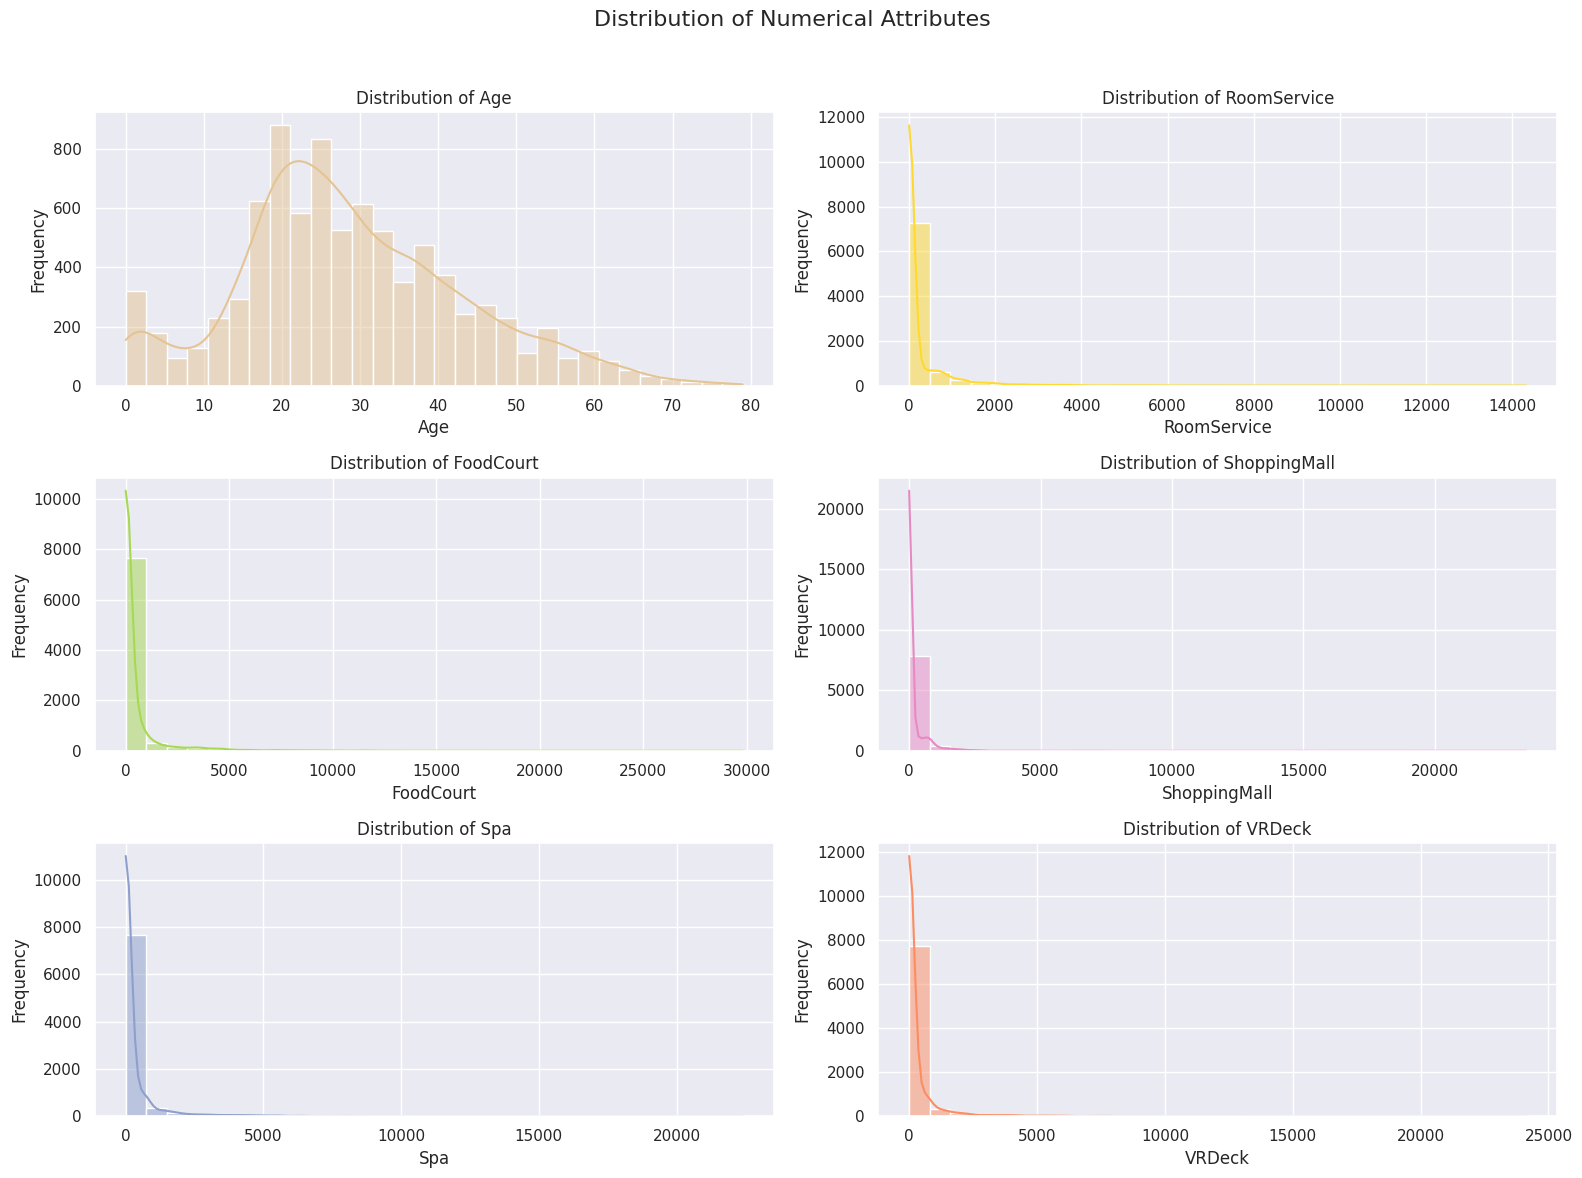

In [135]:
palette = sns.color_palette('Set2_r', n_colors=len(numerical_cols))

plt.figure(figsize=(16, 12))
plt.suptitle('Distribution of Numerical Attributes', fontsize=16)

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_tr[col], kde=True, bins=30, color=palette[i])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [136]:
# Dados de teste
numerical_cols = df_ts.select_dtypes(include=['float64']).columns
stats = df_ts[numerical_cols].describe().T
stats['std'] = df_ts[numerical_cols].std()
stats = stats.round(2)  # arredonda para 2 casas decimais

stats = stats.rename(columns={
    'min': 'Mínimo',
    'max': 'Máximo',
    'mean': 'Média',
    'std': 'Desvio-Padrão',
    '25%': '1º Quartil (25%)',
    '50%': 'Mediana (50%)',
    '75%': '3º Quartil (75%)'
})

display(stats[['Mínimo', 'Média', 'Máximo', 'Desvio-Padrão']])

,Mínimo,Média,Máximo,Desvio-Padrão
Age,0.0,28.66,79.0,14.18
RoomService,0.0,219.27,11567.0,607.01
FoodCourt,0.0,439.48,25273.0,1527.66
ShoppingMall,0.0,177.30,8292.0,560.82
Spa,0.0,303.05,19844.0,1117.19
VRDeck,0.0,310.71,22272.0,1246.99


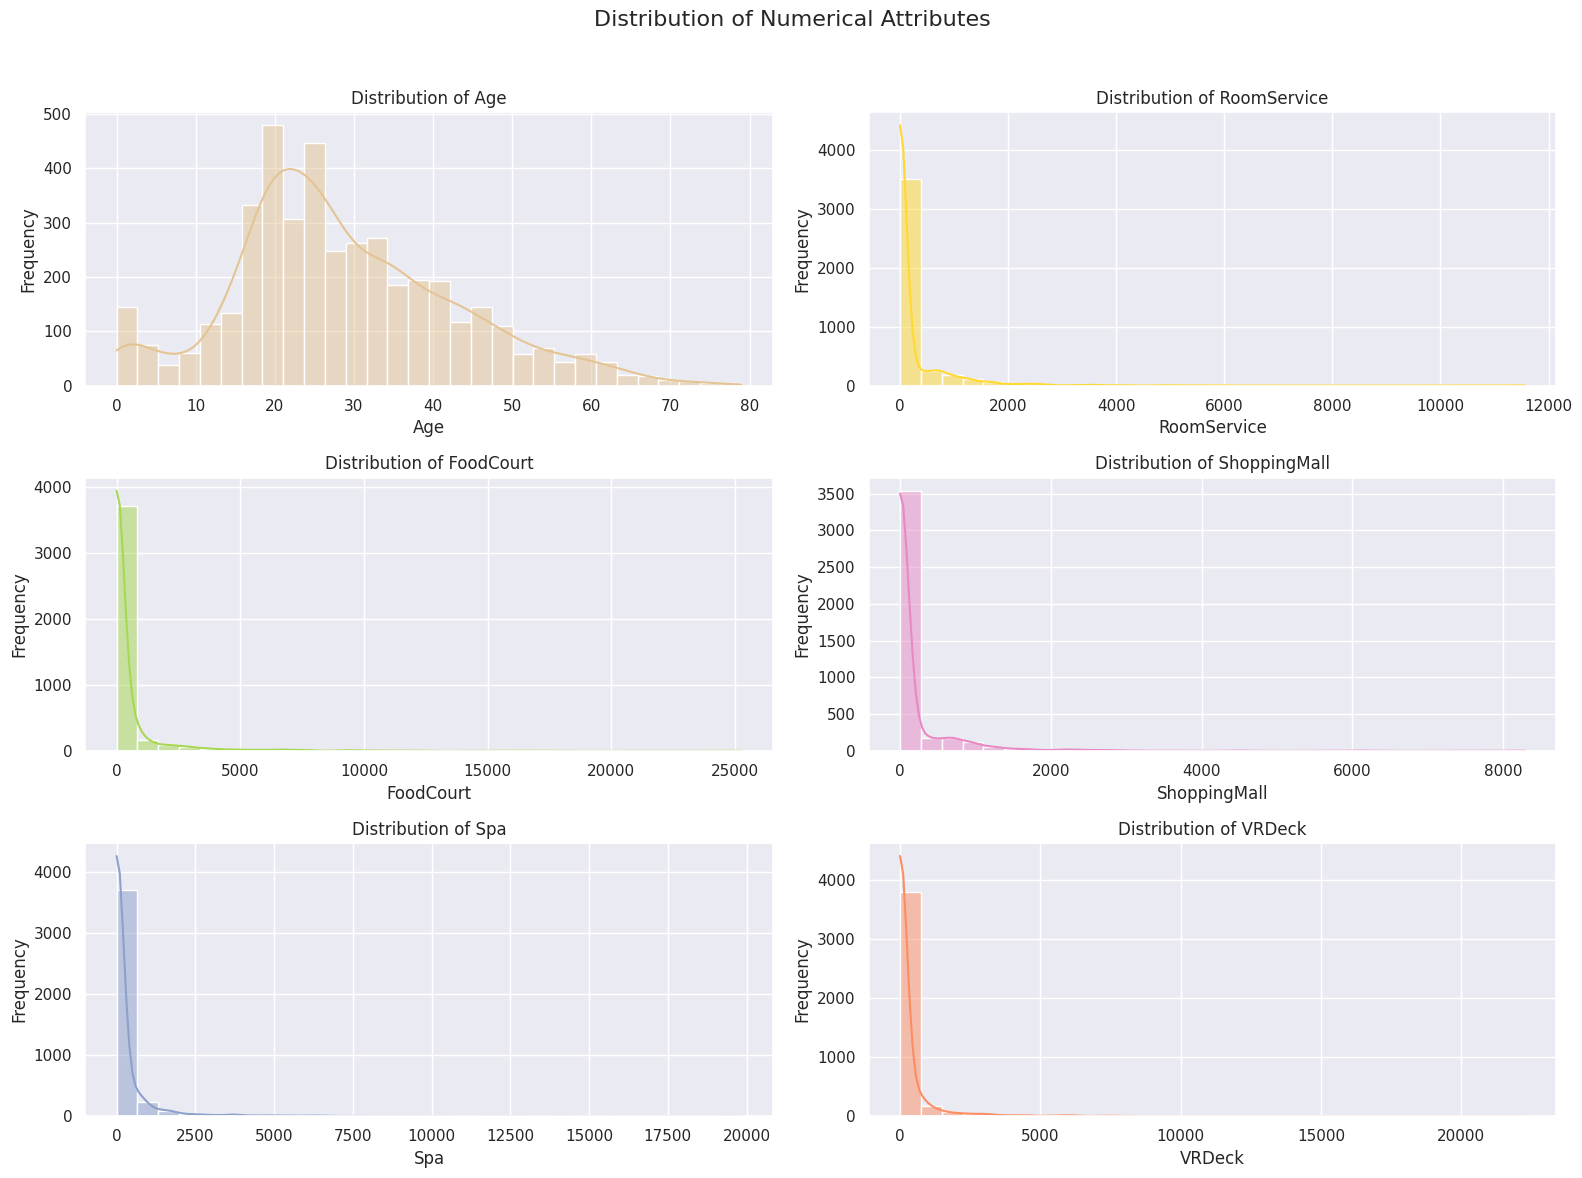

In [137]:
palette = sns.color_palette('Set2_r', n_colors=len(numerical_cols))

plt.figure(figsize=(16, 12))
plt.suptitle('Distribution of Numerical Attributes', fontsize=16)

for i, col in enumerate(numerical_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_ts[col], kde=True, bins=30, color=palette[i])
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## c)

In [138]:
binary_cols = ['CryoSleep', 'VIP', 'Transported']
print("Binary Attributes:\n")
for col in binary_cols:
    print(f"→ {col}")
    print(df_tr[col].value_counts(dropna=False))
    print("-" * 40)

Binary Attributes:

→ CryoSleep
CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64
----------------------------------------
→ VIP
VIP
False    8291
NaN       203
True      199
Name: count, dtype: int64
----------------------------------------
→ Transported
Transported
True     4378
False    4315
Name: count, dtype: int64
----------------------------------------


In [139]:
nominal_cols = ['PassengerId', 'HomePlanet', 'Cabin', 'Destination', 'Name']
print("\nNominal Attributes:\n")
for col in nominal_cols:
    print(f"→ {col}")
    print(df_tr[col].value_counts(dropna=False))
    print("-" * 40)


Nominal Attributes:

→ PassengerId
PassengerId
9280_02    1
0001_01    1
0002_01    1
0003_01    1
0003_02    1
          ..
0008_01    1
0007_01    1
0006_02    1
0006_01    1
0005_01    1
Name: count, Length: 8693, dtype: int64
----------------------------------------
→ HomePlanet
HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64
----------------------------------------
→ Cabin
Cabin
NaN         199
G/734/S       8
G/1368/P      7
G/109/P       7
C/21/P        7
           ... 
G/545/S       1
G/543/S       1
B/106/P       1
G/542/S       1
F/702/P       1
Name: count, Length: 6561, dtype: int64
----------------------------------------
→ Destination
Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: count, dtype: int64
----------------------------------------
→ Name
Name
NaN                   200
Ankalik Nateansive      2
Gwendy Sykess           2
Cuses Pread             2
Keitha Jo

## d)

In [140]:
def missing_values(df, flag='train'):
    """
    Exibe um resumo dos valores ausentes no DataFrame fornecido.

    Parâmetros:
    - df (pd.DataFrame): DataFrame a ser analisado.
    - flag (str): Indica se os dados são de 'train' ou 'test' (usado apenas no display).
    """
    missing = df.isnull().sum()
    missing_percent = (missing / len(df)) * 100

    missing_summary = pd.DataFrame({
        'Missing Values': missing,
        'Percent (%)': missing_percent.round(2)
    }).sort_values(by='Percent (%)', ascending=False)
    display(missing_summary[missing_summary['Missing Values'] > 0])
    #return missing_summary[missing_summary['Missing Values'] > 0]

In [141]:
missing_values(df_tr, 'train')
missing_values(df_ts, 'test')

,Missing Values,Percent (%)
CryoSleep,217,2.50
ShoppingMall,208,2.39
VIP,203,2.34
HomePlanet,201,2.31
Name,200,2.30
Cabin,199,2.29
VRDeck,188,2.16
Spa,183,2.11
FoodCourt,183,2.11
Destination,182,2.09


,Missing Values,Percent (%)
FoodCourt,106,2.48
Spa,101,2.36
Cabin,100,2.34
ShoppingMall,98,2.29
Name,94,2.20
VIP,93,2.17
CryoSleep,93,2.17
Destination,92,2.15
Age,91,2.13
HomePlanet,87,2.03


In [142]:
def detect_outliers_iqr(df, flag='train'):
    """
    Detecta e resume a contagem de outliers nas colunas numéricas de um DataFrame usando o método do IQR.

    Parâmetros:
    - df (pd.DataFrame): DataFrame a ser analisado.
    - flag (str): Identificador para exibição (ex: 'train', 'test').

    Retorna:
    - pd.DataFrame com contagem de outliers por coluna (somente colunas com pelo menos 1 outlier).
    """
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    outlier_summary = {}

    for col in numerical_cols:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_summary[col] = len(outliers)

    outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['Outlier Count'])
    outlier_df = outlier_df[outlier_df['Outlier Count'] > 0]
    display(outlier_df)
    #return outlier_df

In [143]:
detect_outliers_iqr(df_tr, 'train')
detect_outliers_iqr(df_ts, 'test')

,Outlier Count
Age,77
RoomService,1861
FoodCourt,1823
ShoppingMall,1829
Spa,1788
VRDeck,1809


,Outlier Count
Age,54
RoomService,902
FoodCourt,897
ShoppingMall,878
Spa,888
VRDeck,892


In [144]:
def plot_numerical_boxplots(df, flag='train', cols_per_row=3, palette='Set2'):
    """
    Gera boxplots para todas as colunas numéricas de um DataFrame, com cores variadas.

    Parâmetros:
    - df (pd.DataFrame): DataFrame com os dados.
    - flag (str): Identificador para título (ex: 'train', 'test').
    - cols_per_row (int): Número de colunas por linha nos subplots.
    - palette (str ou list): Paleta de cores para os boxplots.
    """
    numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
    total_plots = len(numerical_cols)
    rows = math.ceil(total_plots / cols_per_row)

    palette_list = sns.color_palette(palette, n_colors=total_plots)

    plt.figure(figsize=(6 * cols_per_row, 5 * rows))
    plt.suptitle(f"Boxplots das Features Numéricas - {flag.capitalize()}", fontsize=22)

    for i, col in enumerate(numerical_cols):
        plt.subplot(rows, cols_per_row, i + 1)
        sns.boxplot(x=df[col], color=palette_list[i % len(palette_list)])
        plt.title(col, fontsize=12)
        plt.xlabel('')
        plt.grid(axis='x', linestyle='--', alpha=0.6)

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

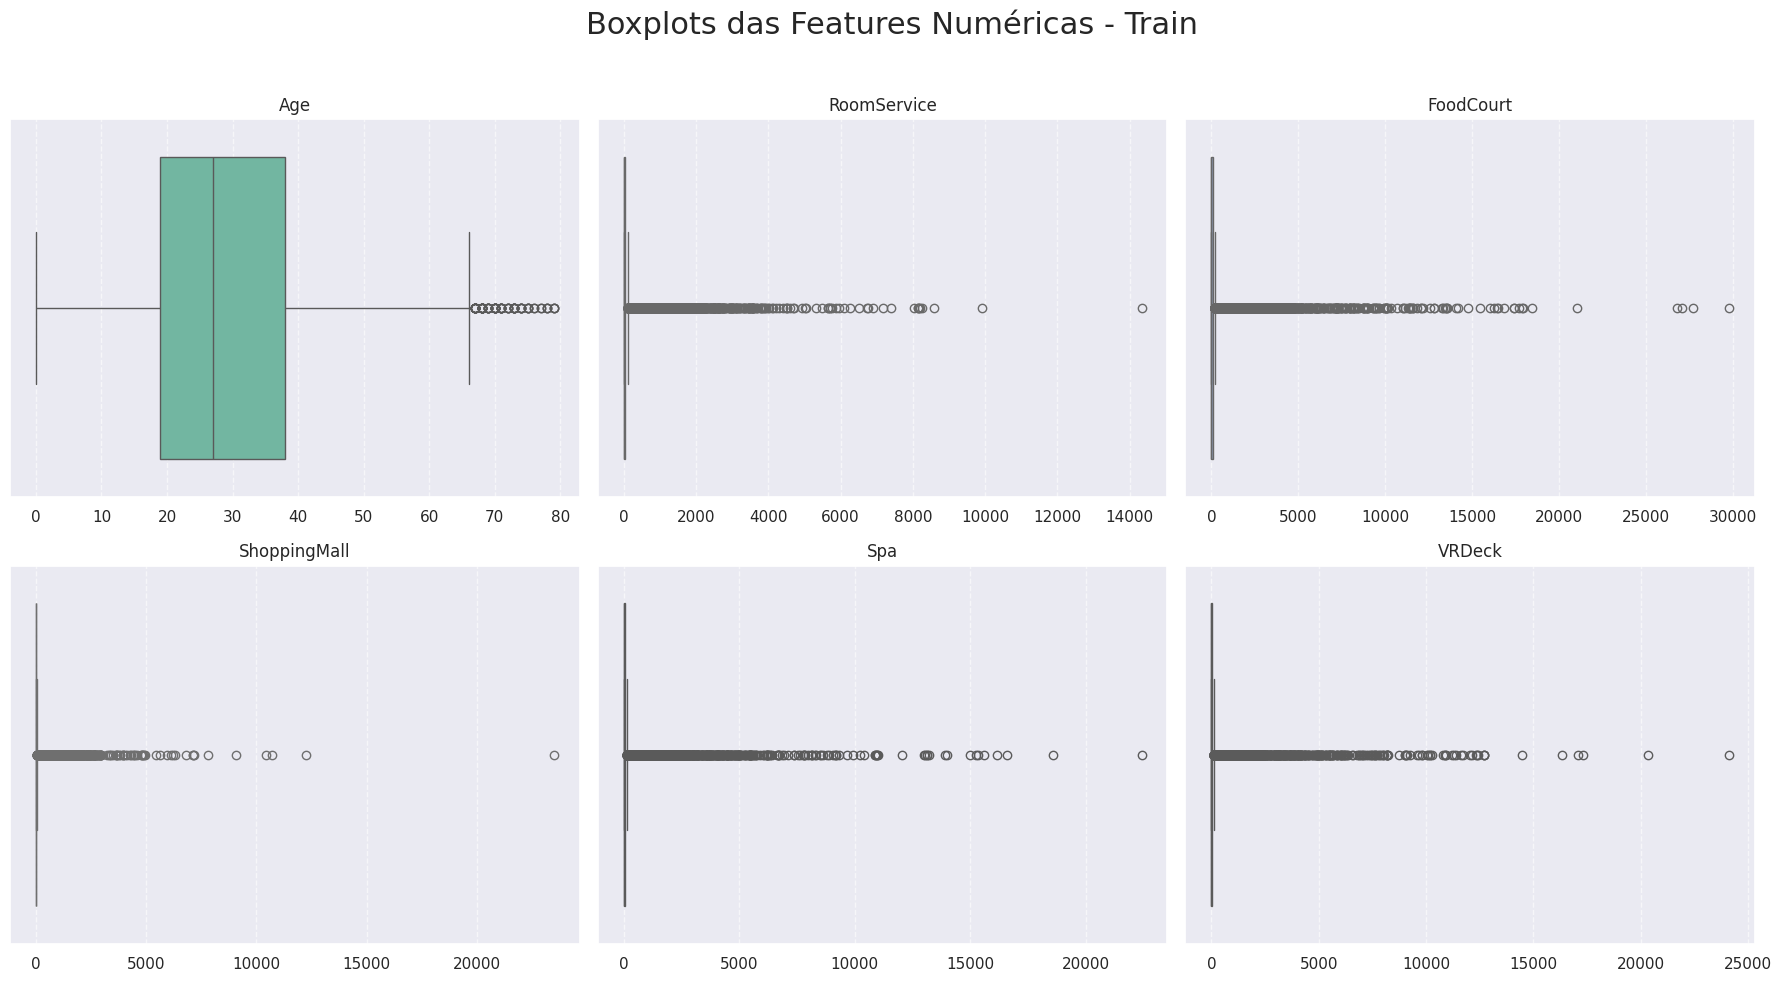

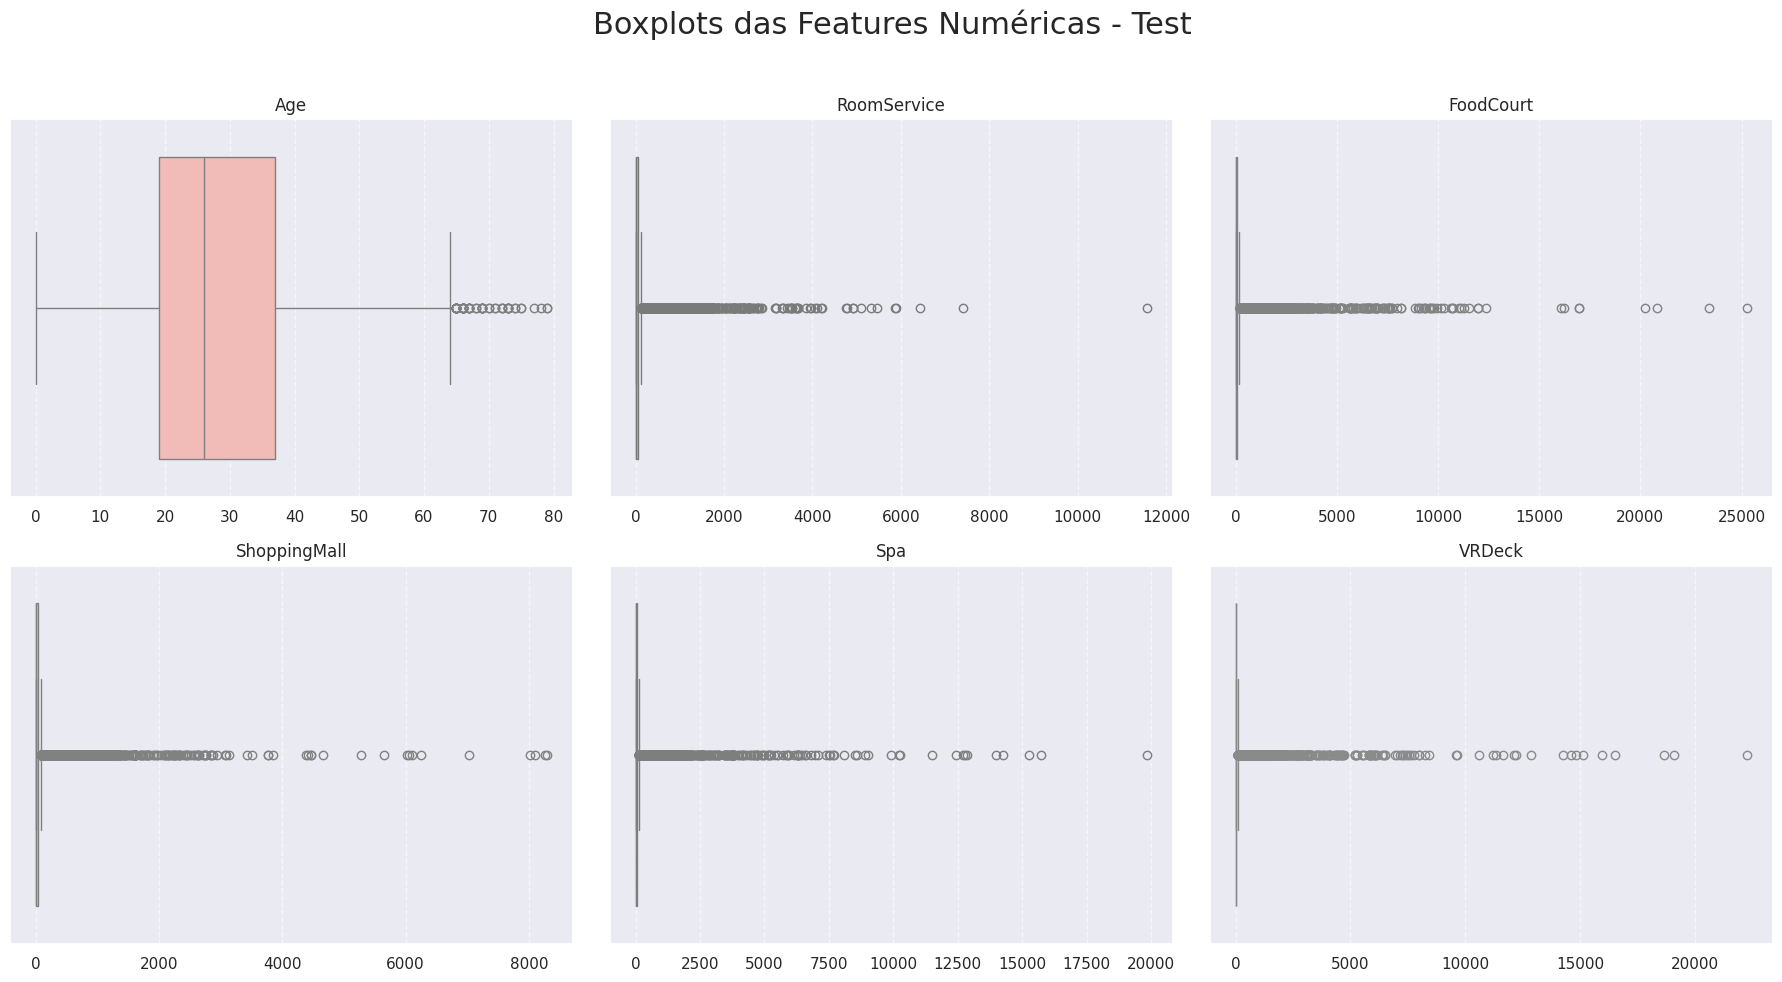

In [145]:
plot_numerical_boxplots(df_tr, 'train')
plot_numerical_boxplots(df_ts, 'test', 3, 'Pastel1')

### Interpretação:

#### 1. **Age**:
- Distribuição relativamente simétrica.
- Alguns poucos outliers em faixas etárias mais elevadas.

#### 2. **RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**:
- Distribuições **fortemente assimétricas à direita (right-skewed)**.
- A maioria dos passageiros gastou pouco ou nada.
- Há muitos **outliers** com gastos extremamente altos.
- Os "bigodes" são pequenos, e os **pontos isolados** indicam pessoas que gastaram muito.

In [146]:
# Age <= 0 é inconsistente
df_tr[df_tr['Age'] <= 0]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
19,0017_01,Earth,False,G/0/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Lyde Brighttt,True
61,0067_01,Earth,True,G/10/S,PSO J318.5-22,0.0,False,0.0,0.0,0.0,0.0,0.0,Ninaha Leeves,True
86,0092_02,Earth,True,G/9/P,TRAPPIST-1e,0.0,False,0.0,0.0,NaN,0.0,0.0,Stald Hewson,True
102,0108_03,Earth,False,G/19/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,0.0,0.0,0.0,Oline Handertiz,True
157,0179_02,Earth,False,G/26/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Raque Webstephrey,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8494,9074_01,Earth,True,G/1460/S,TRAPPIST-1e,0.0,NaN,0.0,0.0,NaN,0.0,0.0,Adamie Trerady,True
8584,9163_01,Earth,True,G/1477/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Idace Edwartizman,True
8650,9227_04,Earth,True,G/1498/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Robyny Hinglendez,True
8654,9231_02,Mars,False,F/1888/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Walls Paie,True


In [147]:
# Age <= 0 é inconsistente
df_ts[df_ts['Age'] <= 0]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
60,0142_03,Mars,False,F/30/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Gacke Buth
77,0175_01,Earth,True,G/25/P,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Celis Benney
231,0495_02,Earth,True,G/73/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Monard Richan
236,0496_01,Earth,False,G/77/P,55 Cancri e,0.0,False,NaN,0.0,0.0,0.0,0.0,Belix Kennetty
284,0625_01,Mars,True,F/111/S,55 Cancri e,0.0,False,0.0,0.0,0.0,0.0,0.0,Trise Perie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4125,8960_01,Earth,False,G/1444/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Benja Solon
4127,8960_03,Earth,True,G/1444/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,NaN,Andan Solon
4158,9022_03,Earth,True,F/1748/S,NaN,0.0,False,0.0,0.0,0.0,0.0,0.0,Erice Boyerson
4160,9025_02,Earth,True,G/1454/S,TRAPPIST-1e,0.0,False,0.0,0.0,0.0,0.0,0.0,Philia Whitersone


In [148]:
# Gastos monetários negativos?
monetary_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_tr[monetary_cols].lt(0).any()

,0
RoomService,False
FoodCourt,False
ShoppingMall,False
Spa,False
VRDeck,False


In [149]:
# Gastos monetários negativos?
monetary_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
df_ts[monetary_cols].lt(0).any()

,0
RoomService,False
FoodCourt,False
ShoppingMall,False
Spa,False
VRDeck,False


In [150]:
# CryoSleep == True com gastos? → passageiros em sono criogênico não deveriam gastar nada
df_tr[(df_tr['CryoSleep'] == True) & (df_tr[monetary_cols].sum(axis=1) > 0)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported


In [151]:
# CryoSleep == True com gastos? → passageiros em sono criogênico não deveriam gastar nada
df_ts[(df_ts['CryoSleep'] == True) & (df_ts[monetary_cols].sum(axis=1) > 0)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name


In [152]:
# CryoSleep == True com gastos? → passageiros em sono criogênico não deveriam gastar nada
df_tr[(df_tr['CryoSleep'] == True) & (df_tr[monetary_cols].sum(axis=1) > 0)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported


In [153]:
# CryoSleep == True com gastos? → passageiros em sono criogênico não deveriam gastar nada
df_ts[(df_ts['CryoSleep'] == True) & (df_ts[monetary_cols].sum(axis=1) > 0)]

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name


In [154]:
# Cabin mal formatado (sem 3 partes separadas por "/")
df_tr['Cabin'].dropna().apply(lambda x: len(x.split('/')) != 3).sum()

np.int64(0)

In [155]:
# Cabin mal formatado (sem 3 partes separadas por "/")
df_ts['Cabin'].dropna().apply(lambda x: len(x.split('/')) != 3).sum()

np.int64(0)

## e)

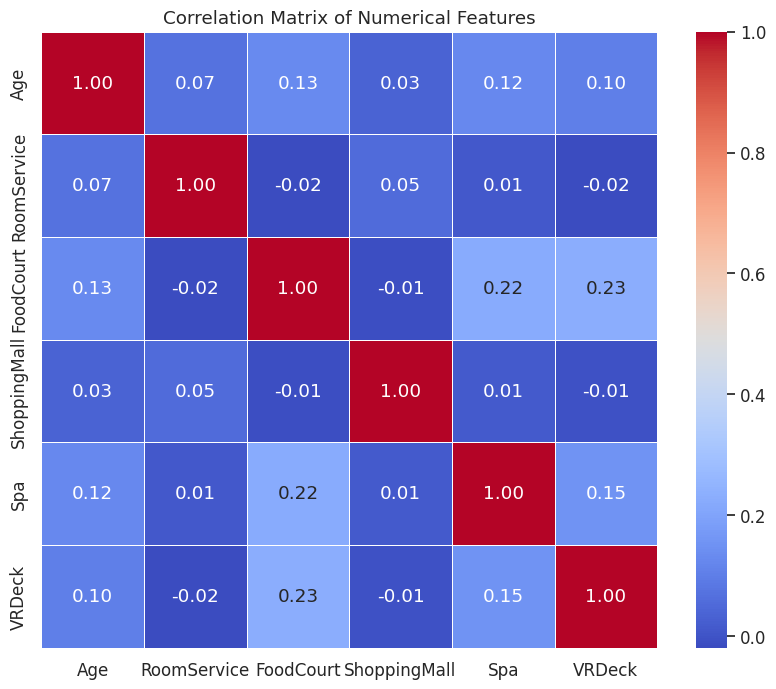

In [156]:
# Apenas dos atributos númericos
numerical_cols = df_tr.select_dtypes(include=['float64', 'int64']).columns

# Matriz de correlação - Dados de treino
corr_matrix_tr = df_tr[numerical_cols].corr()

# Heatmap das correlações
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.1)
sns.heatmap(corr_matrix_tr, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

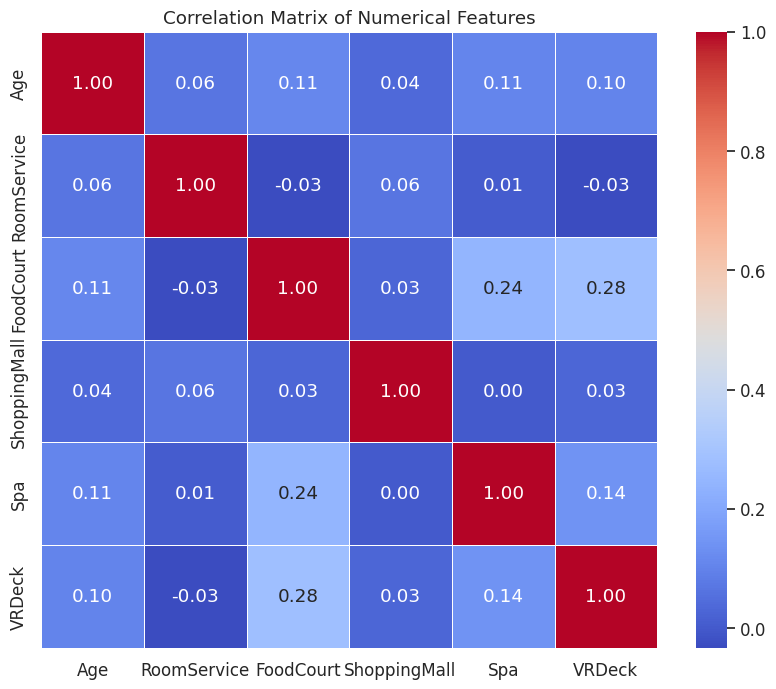

In [157]:
# Apenas dos atributos númericos
numerical_cols = df_ts.select_dtypes(include=['float64', 'int64']).columns

# Matriz de correlação - Dados de teste
corr_matrix_ts = df_ts[numerical_cols].corr()

# Heatmap das correlações
plt.figure(figsize=(10, 8))
sns.set(font_scale=1.1)
sns.heatmap(corr_matrix_ts, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

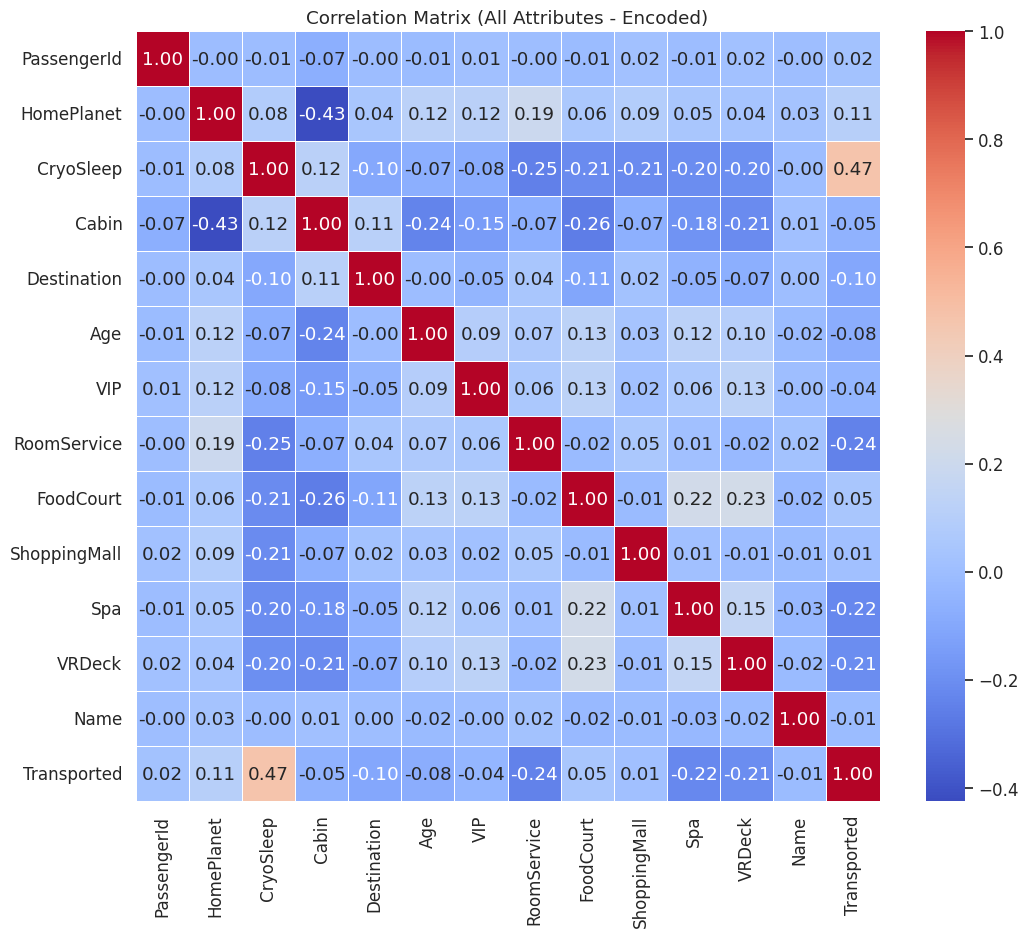

In [158]:
# Usando todos os atributos (não vou usar df original para isso) - Dados de treino
df_encoded_tr = df_tr.copy()

# Converte booleanos para inteiros (True=1, False=0, NaN permanece)
df_encoded_tr['CryoSleep'] = df_encoded_tr['CryoSleep'].astype('float')
df_encoded_tr['VIP'] = df_encoded_tr['VIP'].astype('float')
df_encoded_tr['Transported'] = df_encoded_tr['Transported'].astype('float')

# Transforma atributos categóricos nominais em números arbitrários
categorical_cols = df_encoded_tr.select_dtypes(include='object').columns
encoder = OrdinalEncoder()
df_encoded_tr[categorical_cols] = encoder.fit_transform(df_encoded_tr[categorical_cols].astype(str))

# Heatmap das correlações
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded_tr.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (All Attributes - Encoded)')
plt.show()

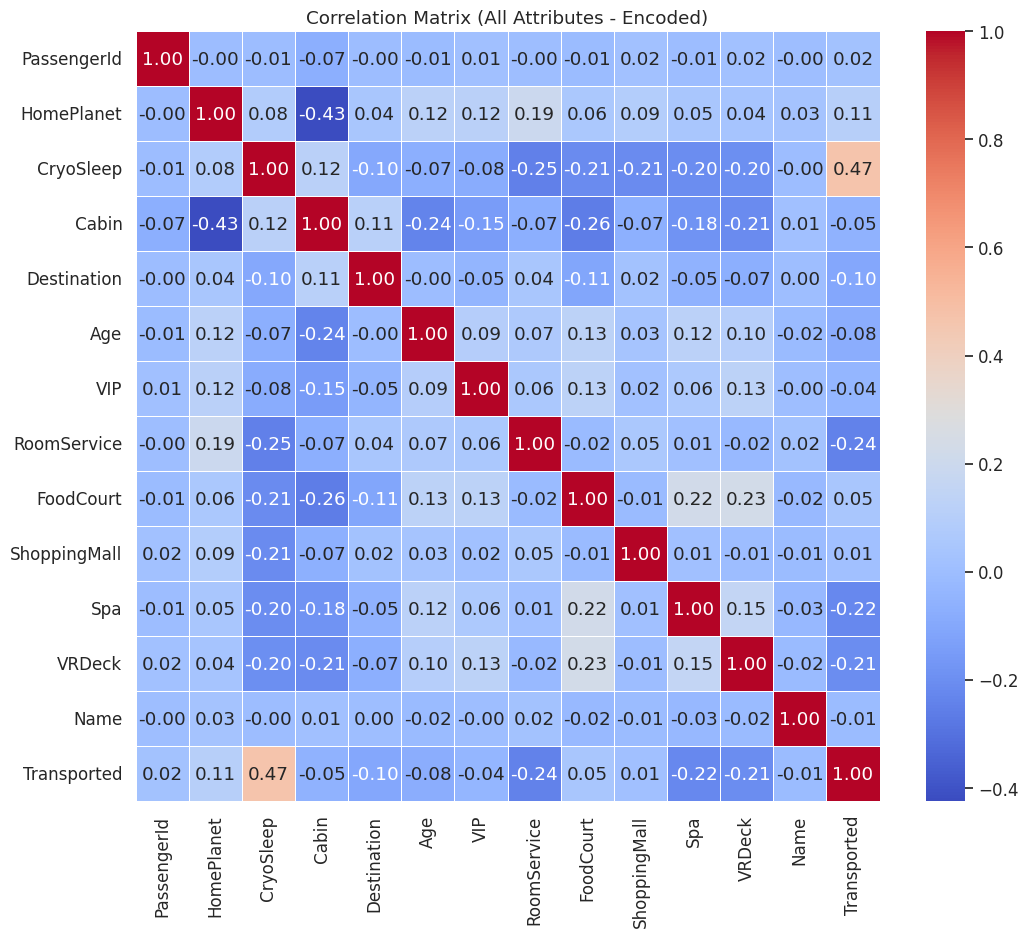

In [159]:
# Usando todos os atributos (não vou usar df original para isso) - Dados de teste
df_encoded_ts = df_tr.copy()

# Converte booleanos para inteiros (True=1, False=0, NaN permanece)
df_encoded_ts['CryoSleep'] = df_encoded_ts['CryoSleep'].astype('float')
df_encoded_ts['VIP'] = df_encoded_ts['VIP'].astype('float')
df_encoded_ts['Transported'] = df_encoded_ts['Transported'].astype('float')

# Transforma atributos categóricos nominais em números arbitrários
categorical_cols = df_encoded_ts.select_dtypes(include='object').columns
encoder = OrdinalEncoder()
df_encoded_ts[categorical_cols] = encoder.fit_transform(df_encoded_ts[categorical_cols].astype(str))

# Heatmap das correlações
plt.figure(figsize=(12, 10))
sns.heatmap(df_encoded_ts.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix (All Attributes - Encoded)')
plt.show()

# Questão 2

## a)

Utilizar o valor mais provável para preencher o valor
ausente: inferência a partir da fórmula de Bayes ou árvores
de decisão.

In [160]:
def impute_with_decision_tree(df, target_col):
    """
    Imputes missing values in a given column using a Decision Tree model.
    Automatically selects a classifier for categorical targets and a regressor for numeric targets.

    Parameters:
    - df (pd.DataFrame): The dataset with missing values.
    - target_col (str): The name of the column to impute.

    Returns:
    - pd.DataFrame: A copy of the original DataFrame with missing values imputed in the target column.
    """
    df_copy = df.copy()

    # Separate rows where the target column is missing and not missing
    df_missing = df_copy[df_copy[target_col].isnull()]
    df_not_missing = df_copy[df_copy[target_col].notnull()]

    # If there's nothing to impute (all missing or all filled), return unchanged copy
    if df_missing.empty or df_not_missing.empty:
        return df_copy

    # Features (X) and target (y)
    X = df_not_missing.drop(columns=[target_col])
    y = df_not_missing[target_col]
    X_missing = df_missing.drop(columns=[target_col])

    # Drop non-predictive or highly missing columns
    drop_cols = ['PassengerId', 'Name', 'Cabin']
    X = X.drop(columns=[col for col in drop_cols if col in X.columns])
    X_missing = X_missing.drop(columns=[col for col in drop_cols if col in X_missing.columns])

    # Encode categorical and boolean features
    encoders = {}
    for col in X.columns:
        if X[col].dtype == 'object' or X[col].dtype == 'bool':
            le = LabelEncoder()
            full_col = pd.concat([X[col], X_missing[col]])
            le.fit(full_col.astype(str))
            X[col] = le.transform(X[col].astype(str))
            X_missing[col] = le.transform(X_missing[col].astype(str))
            encoders[col] = le

    # Decide model based on target type
    if y.dtype == 'object' or y.dtype == 'bool':
        # Classification for categorical/boolean target
        model = DecisionTreeClassifier()
        y_enc = LabelEncoder().fit_transform(y.astype(str))
        model.fit(X, y_enc)
        pred = model.predict(X_missing)

        # Decode predicted labels
        pred_labels = LabelEncoder().fit(y.astype(str)).inverse_transform(pred)
        df_copy.loc[df_copy[target_col].isnull(), target_col] = pred_labels
    else:
        # Regression for numeric target
        model = DecisionTreeRegressor()
        model.fit(X, y)
        pred = model.predict(X_missing)
        df_copy.loc[df_copy[target_col].isnull(), target_col] = pred

    return df_copy

def impute_data(df, flag='train'):
  print(f'Imputing {flag} data...')
  df_imputed = df.copy()
  missing_cols = df.columns[df.isnull().any()]

  for col in missing_cols:
      print(f'Imputing column: {col}')
      df_imputed = impute_with_decision_tree(df_imputed, col)

  print()
  return df_imputed

df_tr_imputed = impute_data(df_tr)
df_ts_imputed = impute_data(df_ts, 'test')

Imputing train data...
Imputing column: HomePlanet
Imputing column: CryoSleep
Imputing column: Cabin
Imputing column: Destination
Imputing column: Age
Imputing column: VIP
Imputing column: RoomService
Imputing column: FoodCourt
Imputing column: ShoppingMall
Imputing column: Spa
Imputing column: VRDeck
Imputing column: Name

Imputing test data...
Imputing column: HomePlanet
Imputing column: CryoSleep
Imputing column: Cabin
Imputing column: Destination
Imputing column: Age
Imputing column: VIP
Imputing column: RoomService
Imputing column: FoodCourt
Imputing column: ShoppingMall
Imputing column: Spa
Imputing column: VRDeck
Imputing column: Name



In [161]:
df_tr_imputed

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [162]:
print('Contagem de ausentes por coluna:\n', df_tr_imputed.isnull().sum(), end='')

Contagem de ausentes por coluna:
 PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

In [163]:
df_ts_imputed

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.000000,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.000000,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.000000,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,E/434/P,TRAPPIST-1e,42.000000,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,27.046512,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,TRAPPIST-1e,31.000000,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [164]:
print('Contagem de ausentes por coluna:\n', df_ts_imputed.isnull().sum(), end='')

Contagem de ausentes por coluna:
 PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

## b)

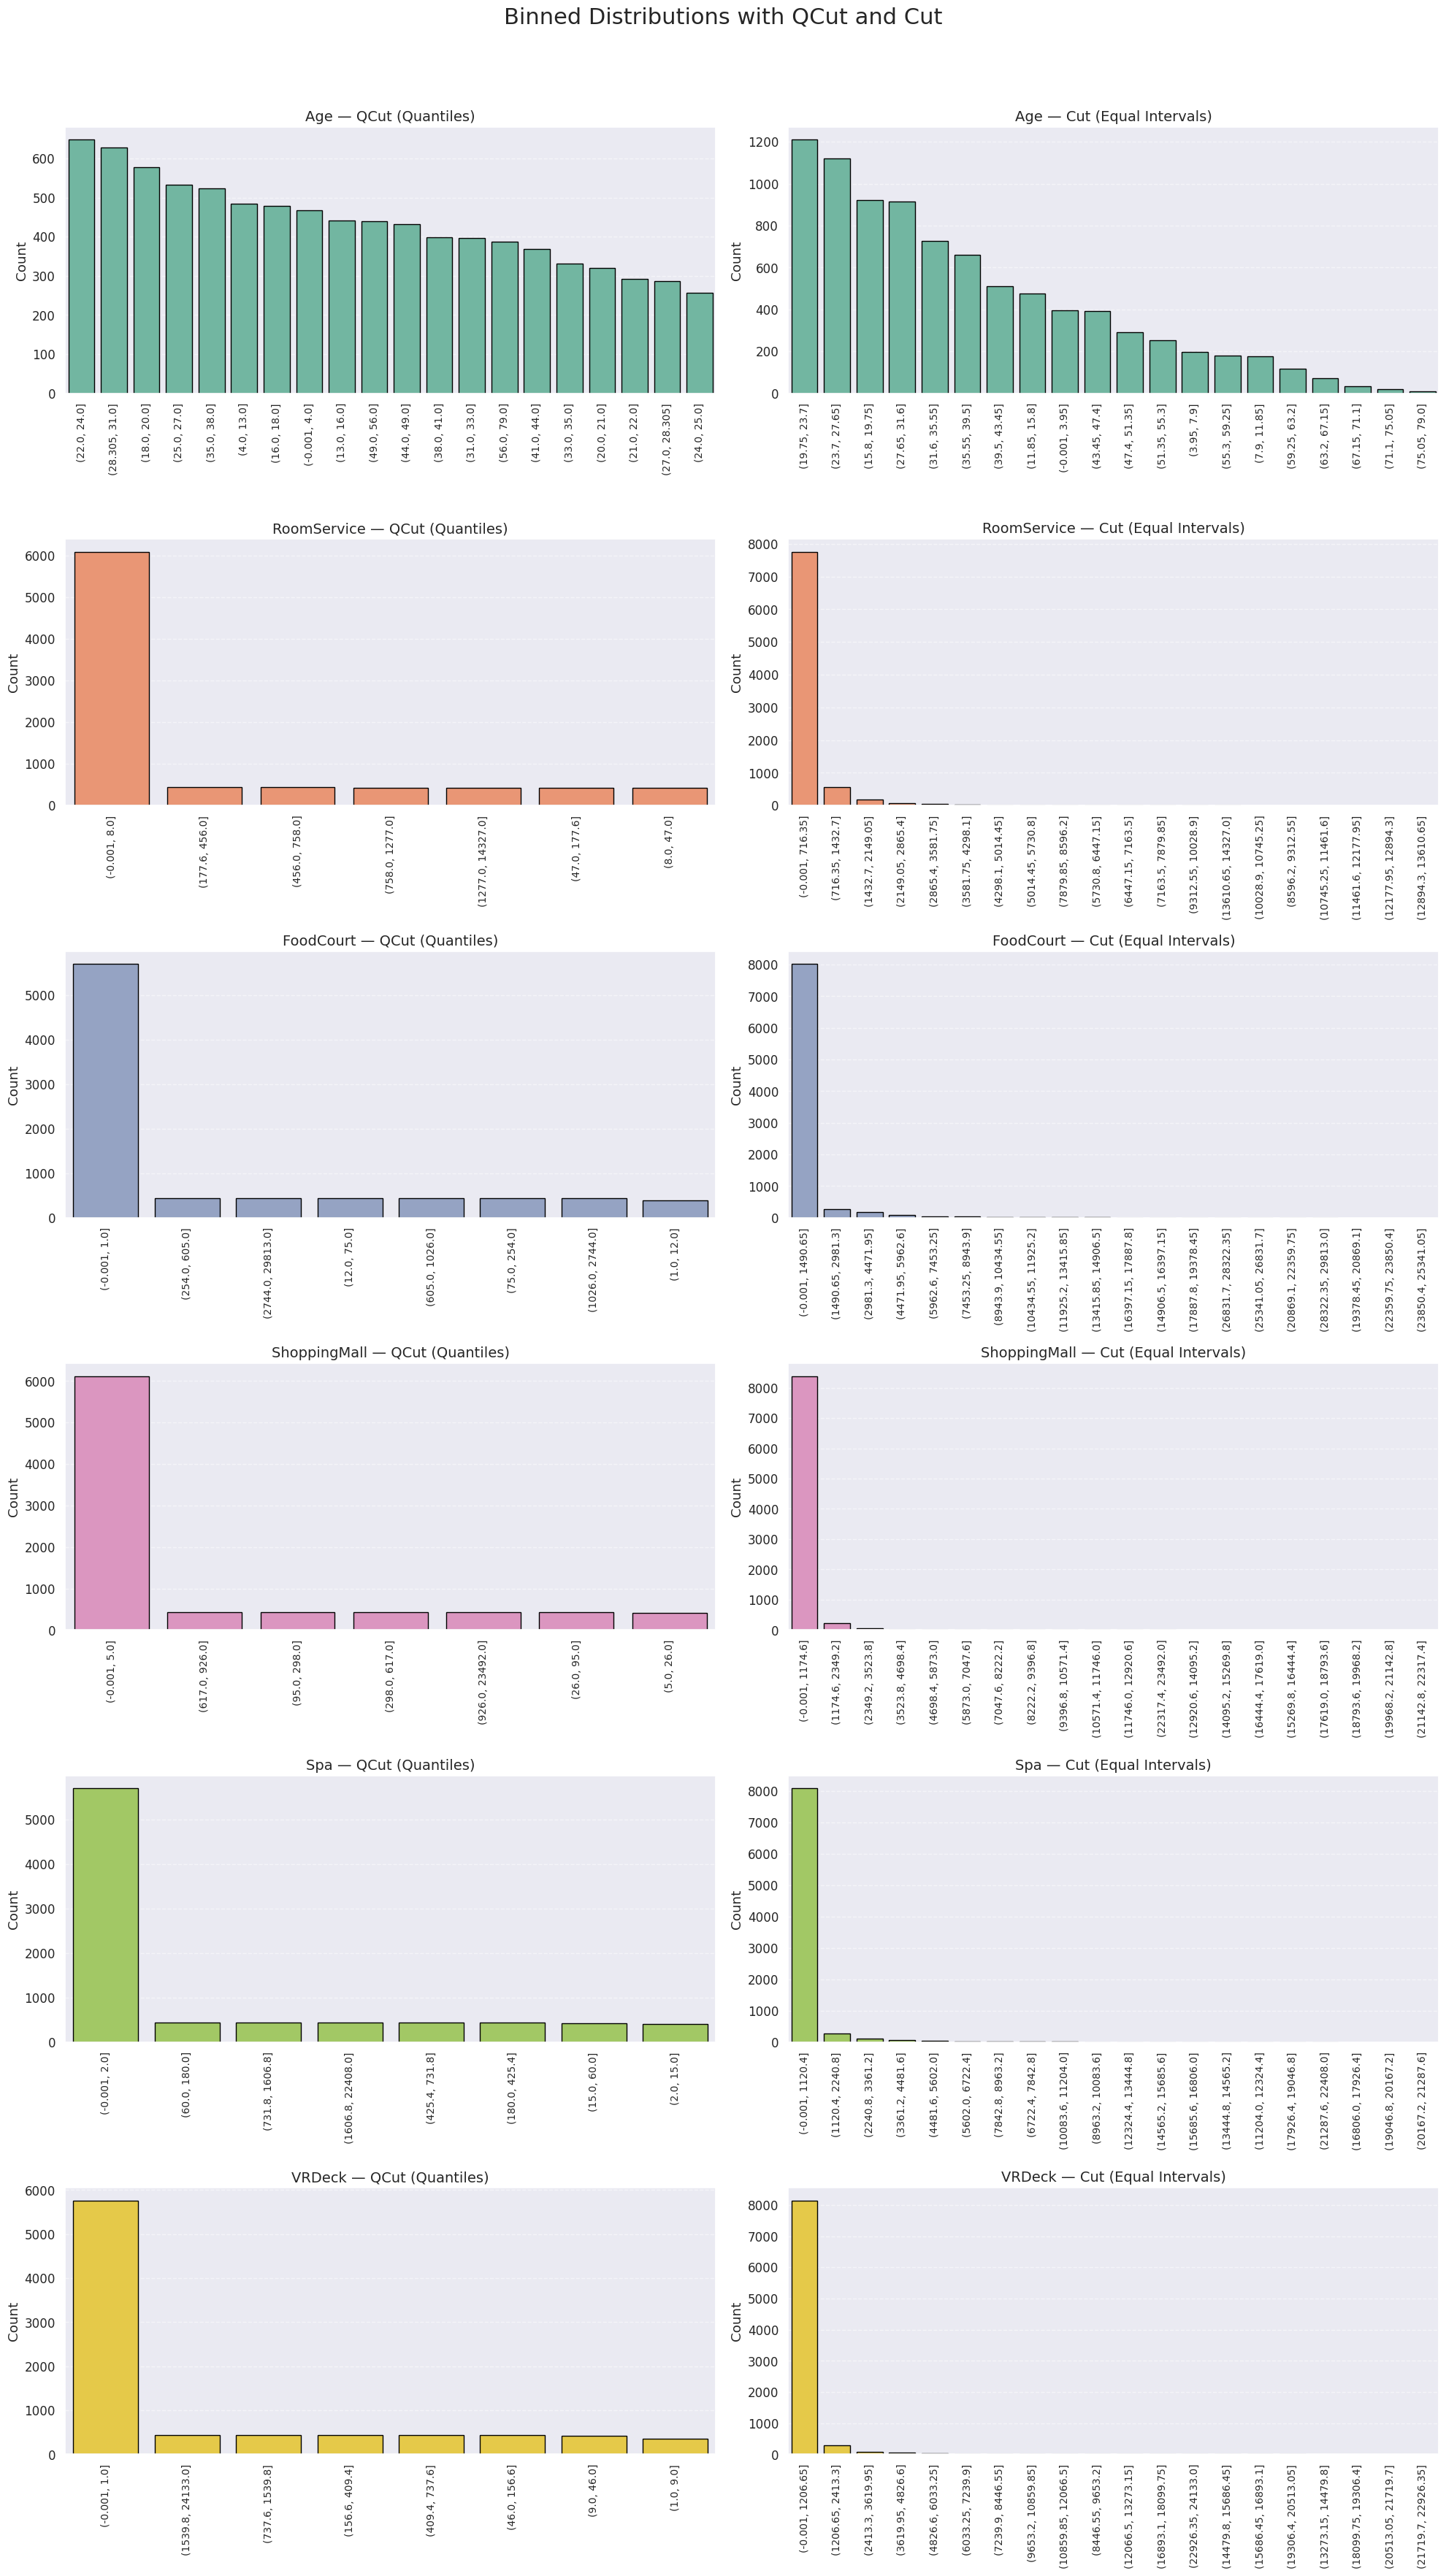

In [165]:
df_binned_tr = df_tr_imputed.copy()

# Parameters
n_bins = 20
numerical_cols = df_binned_tr.select_dtypes(include=['float64', 'int64']).columns
palette_list = sns.color_palette('Set2', n_colors=len(numerical_cols))

# Apply qcut (quantiles)
for col in numerical_cols:
    try:
        df_binned_tr[col + '_qcut'] = pd.qcut(df_binned_tr[col], q=n_bins, duplicates='drop')
    except ValueError as e:
        print(f"qcut failed for column {col}: {e}")

# Apply cut
for col in numerical_cols:
    try:
        min_val = max(0, df_binned_tr[col].min())
        max_val = df_binned_tr[col].max()
        bins = np.linspace(min_val, max_val, n_bins + 1)
        df_binned_tr[col + '_cut'] = pd.cut(df_binned_tr[col], bins=bins, include_lowest=True)
    except ValueError as e:
        print(f"cut failed for column {col}: {e}")

# Plot: 2 columns — qcut on the left, cut on the right
plt.figure(figsize=(20, 6 * len(numerical_cols)))
plt.suptitle('Binned Distributions with QCut and Cut', fontsize=22)

for i, col in enumerate(numerical_cols):
    color = palette_list[i % len(palette_list)]

    # QCut plot
    binned_qcut_col = col + '_qcut'
    plt.subplot(len(numerical_cols), 2, 2*i + 1)
    if binned_qcut_col in df_binned_tr.columns:
        sns.countplot(
            data=df_binned_tr,
            x=binned_qcut_col,
            order=df_binned_tr[binned_qcut_col].value_counts().index,
            color=color,
            edgecolor='black'
        )
        plt.xticks(rotation=90, fontsize=10)
        plt.title(f'{col} — QCut (Quantiles)', fontsize=14)
        plt.xlabel('')
        plt.ylabel('Count')
        plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Cut plot
    binned_cut_col = col + '_cut'
    plt.subplot(len(numerical_cols), 2, 2*i + 2)
    if binned_cut_col in df_binned_tr.columns:
        sns.countplot(
            data=df_binned_tr,
            x=binned_cut_col,
            order=df_binned_tr[binned_cut_col].value_counts().index,
            color=color,
            edgecolor='black'
        )
        plt.xticks(rotation=90, fontsize=10)
        plt.title(f'{col} — Cut (Equal Intervals)', fontsize=14)
        plt.xlabel('')
        plt.ylabel('Count')
        plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

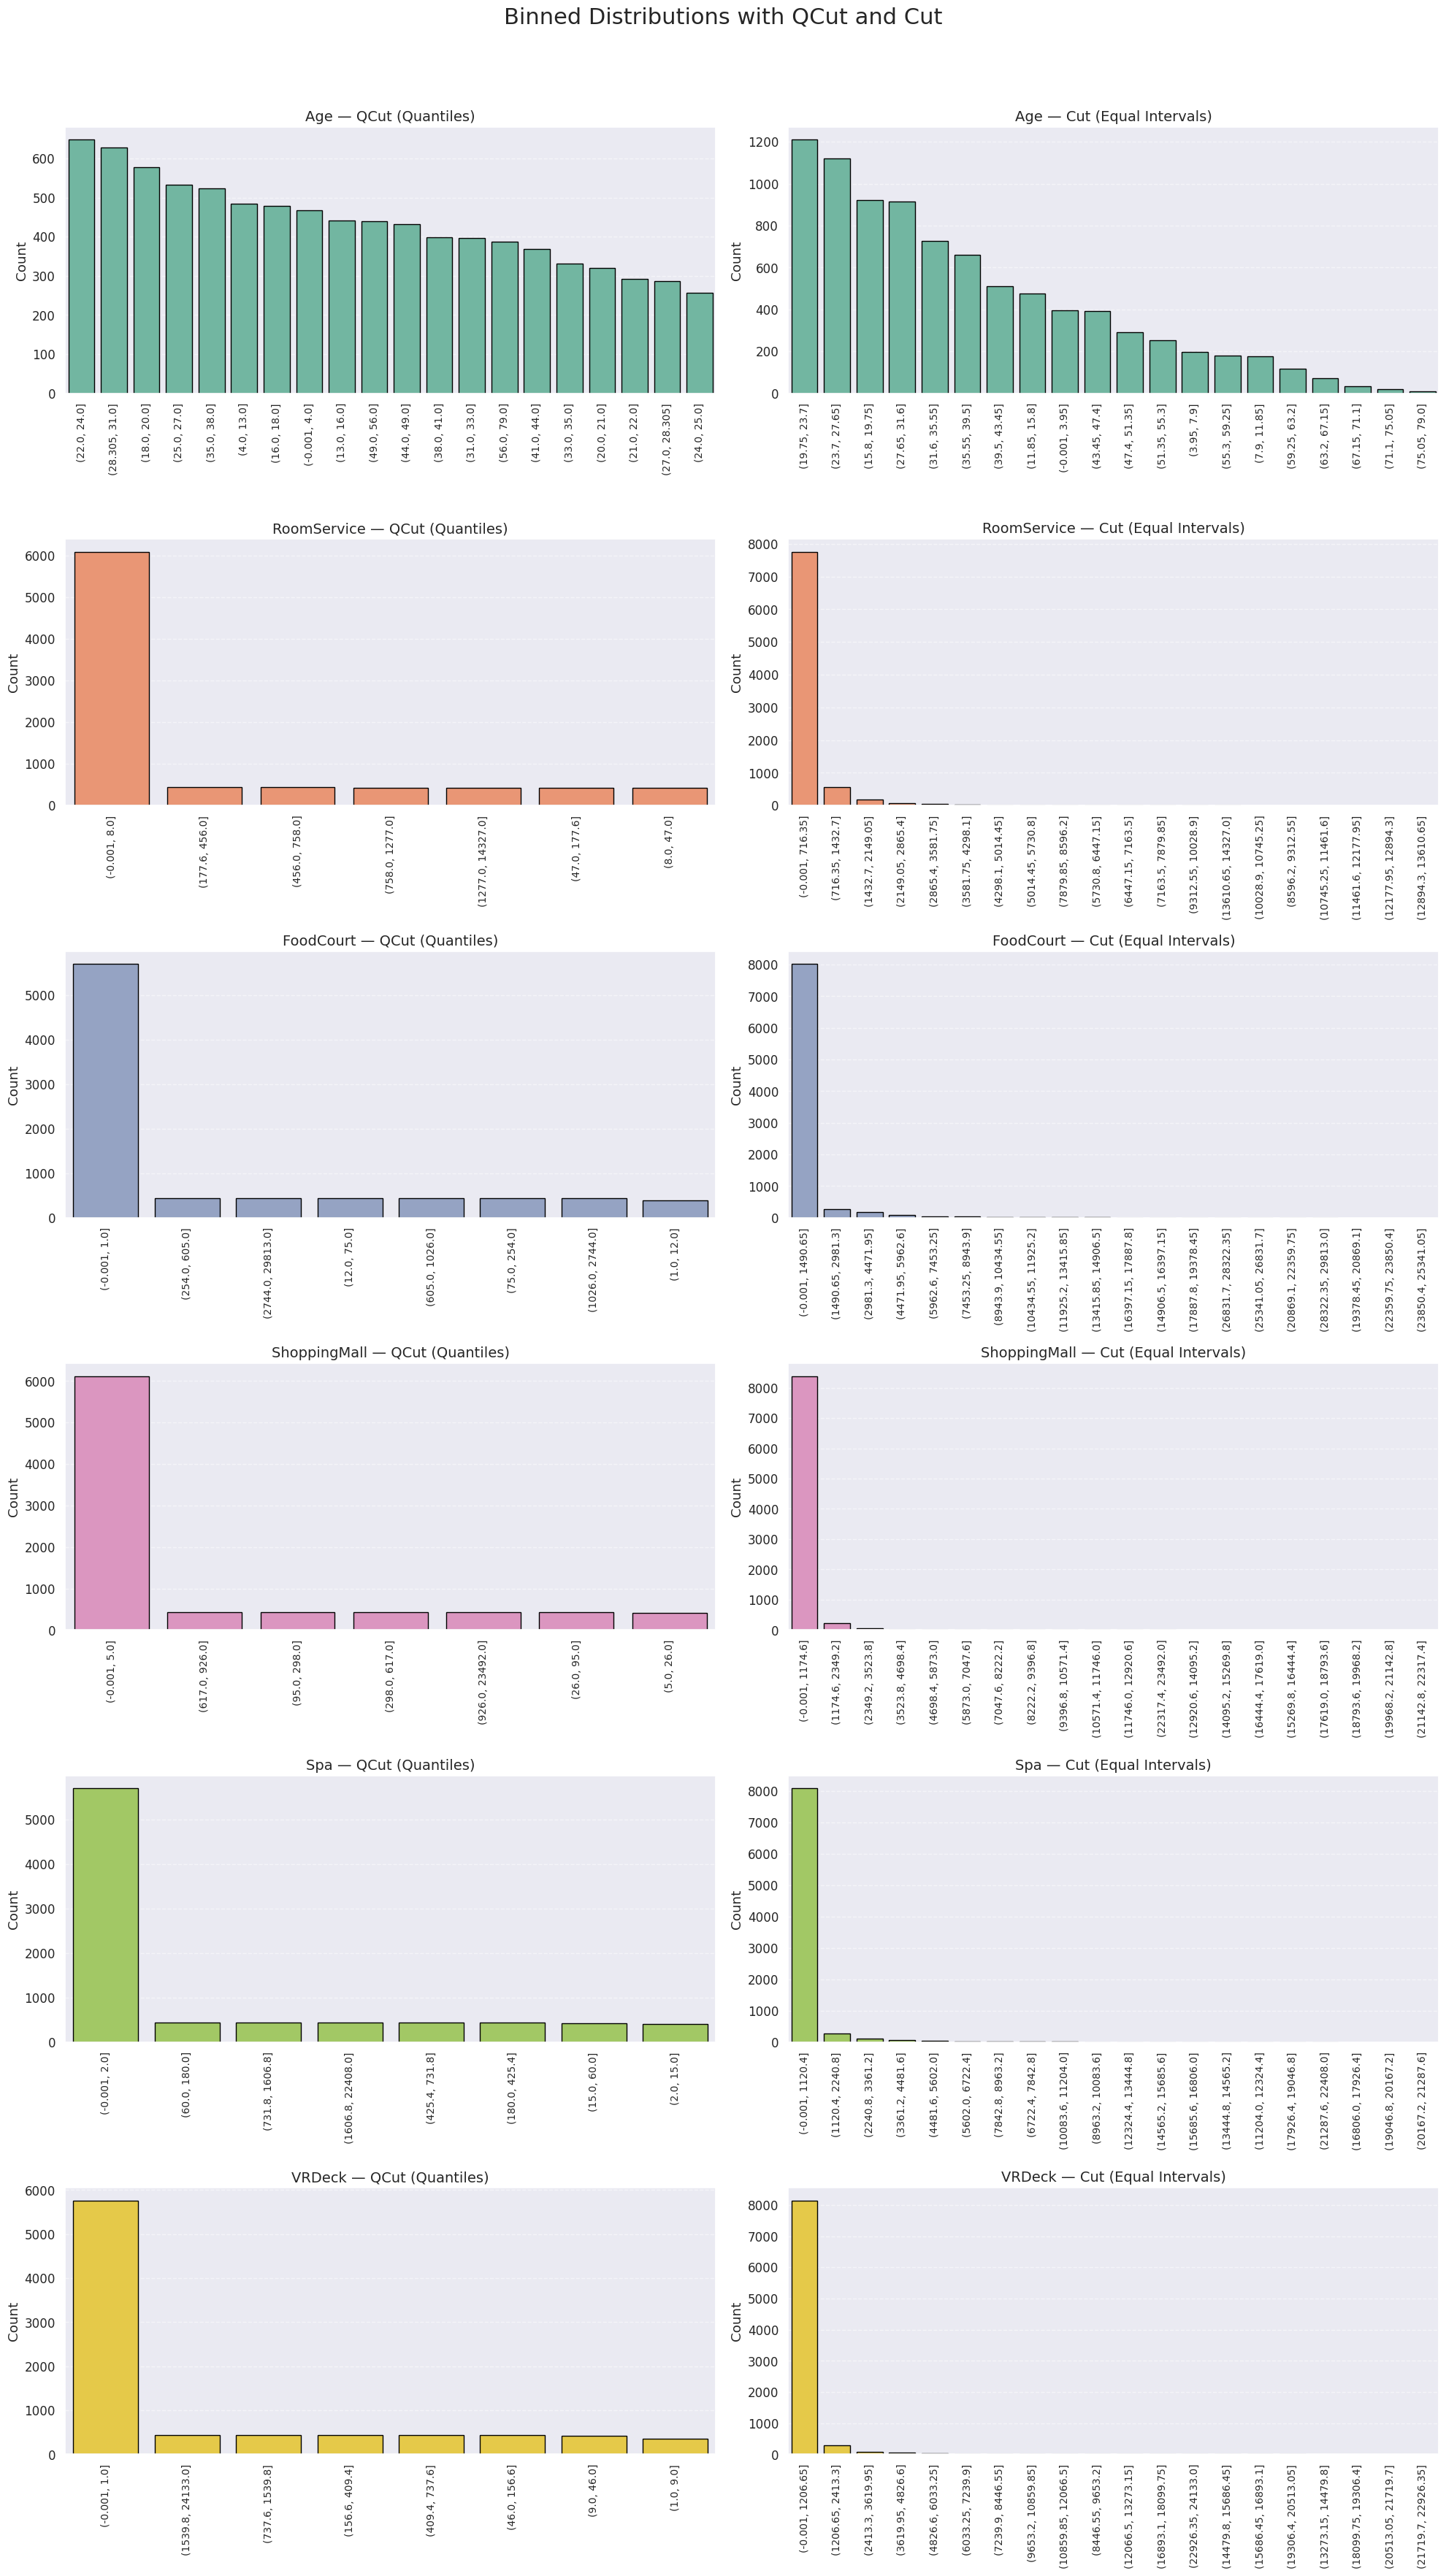

In [166]:
df_binned_ts = df_tr_imputed.copy()

# Parameters
n_bins = 20
numerical_cols = df_binned_ts.select_dtypes(include=['float64', 'int64']).columns
palette_list = sns.color_palette('Set2', n_colors=len(numerical_cols))

# Apply qcut (quantiles)
for col in numerical_cols:
    try:
        df_binned_ts[col + '_qcut'] = pd.qcut(df_binned_ts[col], q=n_bins, duplicates='drop')
    except ValueError as e:
        print(f"qcut failed for column {col}: {e}")

# Apply cut
for col in numerical_cols:
    try:
        min_val = max(0, df_binned_ts[col].min())
        max_val = df_binned_ts[col].max()
        bins = np.linspace(min_val, max_val, n_bins + 1)
        df_binned_ts[col + '_cut'] = pd.cut(df_binned_ts[col], bins=bins, include_lowest=True)
    except ValueError as e:
        print(f"cut failed for column {col}: {e}")

# Plot: 2 columns — qcut on the left, cut on the right
plt.figure(figsize=(20, 6 * len(numerical_cols)))
plt.suptitle('Binned Distributions with QCut and Cut', fontsize=22)

for i, col in enumerate(numerical_cols):
    color = palette_list[i % len(palette_list)]

    # QCut plot
    binned_qcut_col = col + '_qcut'
    plt.subplot(len(numerical_cols), 2, 2*i + 1)
    if binned_qcut_col in df_binned_ts.columns:
        sns.countplot(
            data=df_binned_ts,
            x=binned_qcut_col,
            order=df_binned_ts[binned_qcut_col].value_counts().index,
            color=color,
            edgecolor='black'
        )
        plt.xticks(rotation=90, fontsize=10)
        plt.title(f'{col} — QCut (Quantiles)', fontsize=14)
        plt.xlabel('')
        plt.ylabel('Count')
        plt.grid(axis='y', linestyle='--', alpha=0.5)

    # Cut plot
    binned_cut_col = col + '_cut'
    plt.subplot(len(numerical_cols), 2, 2*i + 2)
    if binned_cut_col in df_binned_ts.columns:
        sns.countplot(
            data=df_binned_ts,
            x=binned_cut_col,
            order=df_binned_ts[binned_cut_col].value_counts().index,
            color=color,
            edgecolor='black'
        )
        plt.xticks(rotation=90, fontsize=10)
        plt.title(f'{col} — Cut (Equal Intervals)', fontsize=14)
        plt.xlabel('')
        plt.ylabel('Count')
        plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## c)

In [167]:
def clip_data(df_imputed):
  df_outlier_treated = df_imputed.copy()
  numerical_cols = df_outlier_treated.select_dtypes(include=['float64', 'int64']).columns

  # Aplica o clipping baseado no IQR
  for col in numerical_cols:
      Q1 = df_outlier_treated[col].quantile(0.25)
      Q3 = df_outlier_treated[col].quantile(0.75)
      IQR = Q3 - Q1
      lower_bound = Q1 - 1.5 * IQR
      upper_bound = Q3 + 1.5 * IQR
      df_outlier_treated[col] = df_outlier_treated[col].clip(lower=lower_bound, upper=upper_bound)

  # Verifica estatísticas após o tratamento
  df_outlier_treated[numerical_cols].describe()
  return df_outlier_treated

In [168]:
df_tr_outlier_treated = clip_data(df_tr_imputed)
df_ts_outlier_treated = clip_data(df_ts_imputed)

In [169]:
df_tr_outlier_treated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [170]:
def plot_clip(df_outlier_treated):
  # Boxplot das numéricas com cores diferentes
  palette_list = sns.color_palette('Set2', n_colors=len(numerical_cols))
  cols_per_row = 3
  total_plots = len(numerical_cols)
  rows = (total_plots + cols_per_row - 1) // cols_per_row

  plt.figure(figsize=(6 * cols_per_row, 5 * rows))
  plt.suptitle("Boxplots of Numerical Features", fontsize=22)

  for i, col in enumerate(numerical_cols):
      plt.subplot(rows, cols_per_row, i + 1)
      sns.boxplot(x=df_outlier_treated[col], color=palette_list[i % len(palette_list)])
      plt.title(col, fontsize=12)
      plt.xlabel('')
      plt.grid(axis='x', linestyle='--', alpha=0.6)

  plt.tight_layout(rect=[0, 0, 1, 0.96])
  plt.show()

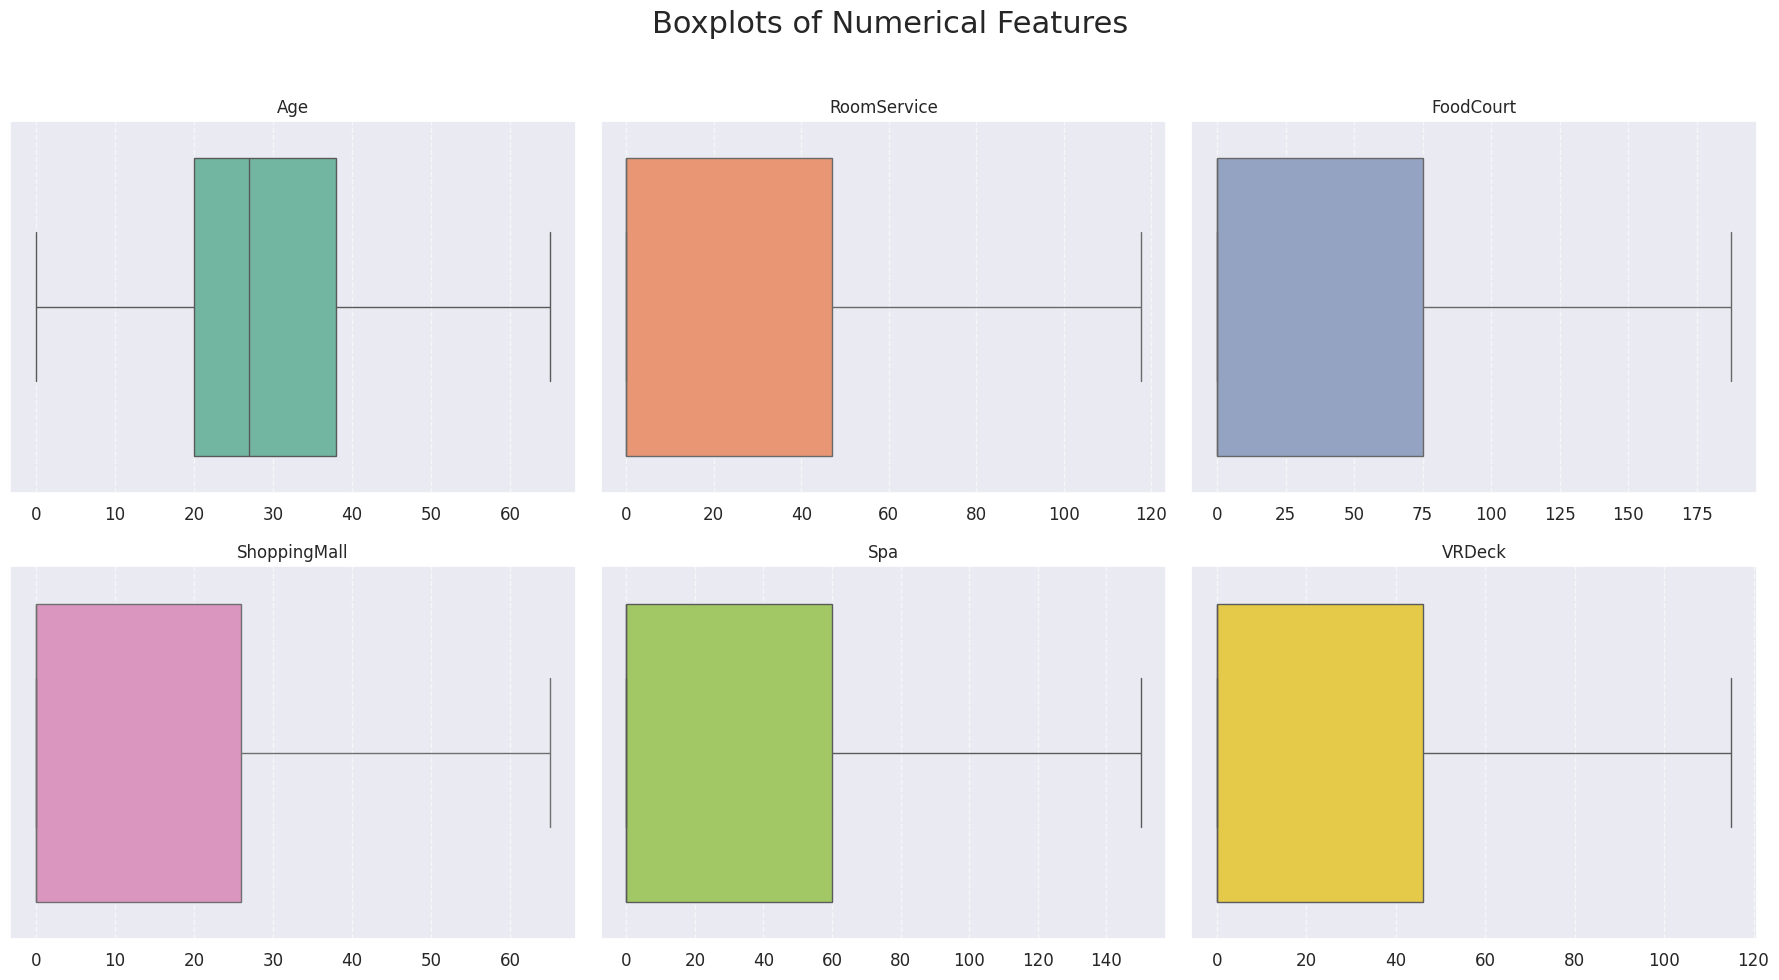

In [171]:
plot_clip(df_tr_outlier_treated)

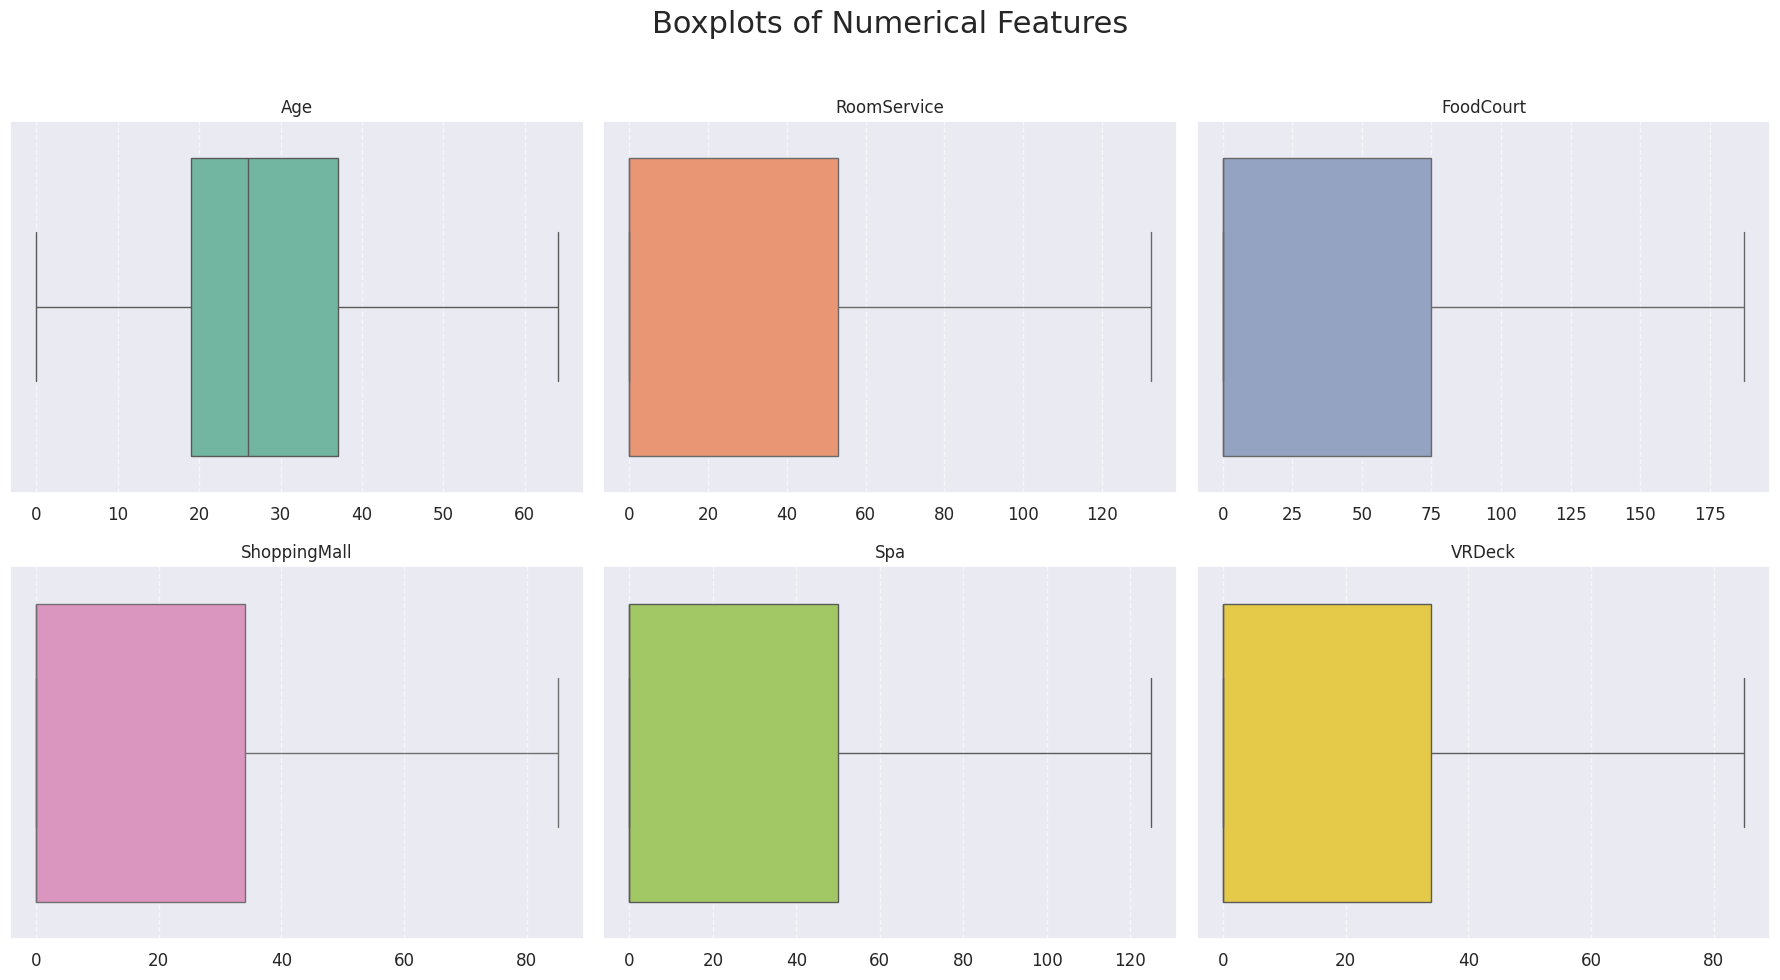

In [172]:
plot_clip(df_ts_outlier_treated)

## d)

In [173]:
print(df_tr_outlier_treated.info())
print()
print(df_ts_outlier_treated.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8693 non-null   object 
 2   CryoSleep     8693 non-null   object 
 3   Cabin         8693 non-null   object 
 4   Destination   8693 non-null   object 
 5   Age           8693 non-null   float64
 6   VIP           8693 non-null   object 
 7   RoomService   8693 non-null   float64
 8   FoodCourt     8693 non-null   float64
 9   ShoppingMall  8693 non-null   float64
 10  Spa           8693 non-null   float64
 11  VRDeck        8693 non-null   float64
 12  Name          8693 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null C

In [175]:
df_tr_encoded = df_tr_outlier_treated.copy()
nominal_cols = df_tr_encoded.select_dtypes(include=['object', 'bool']).columns.tolist()

# Remove explicitamente o target da lista
if 'Transported' in nominal_cols:
    nominal_cols.remove('Transported')

# Converte tudo para string (evita problemas de tipos mistos 'object' e 'bool')
df_tr_encoded[nominal_cols] = df_tr_encoded[nominal_cols].astype(str)

# Instancia o OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplica o encoding apenas nas colunas nominais
encoded_array = ohe.fit_transform(df_tr_encoded[nominal_cols])
encoded_col_names = ohe.get_feature_names_out(nominal_cols)

df_ohe = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_tr_encoded.index)
df_tr_encoded = pd.concat([df_tr_encoded, df_ohe], axis=1)
df_tr_encoded.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name_Zinopus Spandisket,Name_Zinor Axlentindy,Name_Zinor Proorbeng,Name_Zinoth Lansuffle,Name_Zosmark Trattle,Name_Zosmark Unaasor,Name_Zosmas Ineedeve,Name_Zosmas Mormonized,Name_Zubeneb Flesping,Name_Zubeneb Pasharne
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,187.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,187.5,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,117.5,70.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
df_ts_encoded = df_ts_outlier_treated.copy()
nominal_cols = df_ts_encoded.select_dtypes(include=['object', 'bool']).columns.tolist()

# Remove explicitamente o target da lista
if 'Transported' in nominal_cols:
    nominal_cols.remove('Transported')

# Converte tudo para string (evita problemas de tipos mistos 'object' e 'bool')
df_ts_encoded[nominal_cols] = df_ts_encoded[nominal_cols].astype(str)

# Instancia o OneHotEncoder
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Aplica o encoding apenas nas colunas nominais
encoded_array = ohe.fit_transform(df_ts_encoded[nominal_cols])
encoded_col_names = ohe.get_feature_names_out(nominal_cols)

df_ohe = pd.DataFrame(encoded_array, columns=encoded_col_names, index=df_ts_encoded.index)
df_ts_encoded = pd.concat([df_ts_encoded, df_ohe], axis=1)
df_ts_encoded.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name_Zinoces Muspereed,Name_Zinon Ativeezy,Name_Zinon Nairconed,Name_Zinoth Pokerheed,Name_Zosmar Asolipery,Name_Zosmar Inkcablel,Name_Zosmas Reswiress,Name_Zubeneb Camaxler,Name_Zubens Blentrary,Name_Zubens Peterive
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,187.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## e)

In [178]:
# Separar o campo 'Cabin' nas três partes: Deck, Número, Lado
df_tr_encoded[['Deck', 'CabinNum', 'Side']] = df_tr_encoded['Cabin'].str.split('/', expand=True)

# Mapear 'Deck' como ordinal
deck_order = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}
df_tr_encoded['Deck'] = df_tr_encoded['Deck'].map(deck_order)

# Converter 'CabinNum' em número
df_tr_encoded['CabinNum'] = pd.to_numeric(df_tr_encoded['CabinNum'], errors='coerce')

# Mapear 'Side' como binário
df_tr_encoded['Side'] = df_tr_encoded['Side'].map({'P': 0, 'S': 1})
df_tr_encoded

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name_Zinoth Lansuffle,Name_Zosmark Trattle,Name_Zosmark Unaasor,Name_Zosmas Ineedeve,Name_Zosmas Mormonized,Name_Zubeneb Flesping,Name_Zubeneb Pasharne,Deck,CabinNum,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,187.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,187.5,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,117.5,70.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,187.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,98,0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1499,1
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1500,1
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,187.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,608,1


In [179]:
# Separar o campo 'Cabin' nas três partes: Deck, Número, Lado
df_ts_encoded[['Deck', 'CabinNum', 'Side']] = df_ts_encoded['Cabin'].str.split('/', expand=True)

# Mapear 'Deck' como ordinal
deck_order = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'T': 7}
df_ts_encoded['Deck'] = df_ts_encoded['Deck'].map(deck_order)

# Converter 'CabinNum' em número
df_ts_encoded['CabinNum'] = pd.to_numeric(df_ts_encoded['CabinNum'], errors='coerce')

# Mapear 'Side' como binário
df_ts_encoded['Side'] = df_ts_encoded['Side'].map({'P': 0, 'S': 1})
df_ts_encoded

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name_Zinoth Pokerheed,Name_Zosmar Asolipery,Name_Zosmar Inkcablel,Name_Zosmas Reswiress,Name_Zubeneb Camaxler,Name_Zubens Blentrary,Name_Zubens Peterive,Deck,CabinNum,Side
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.000000,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,3,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.000000,False,0.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4,1
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.000000,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.000000,False,0.0,187.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.000000,False,10.0,0.0,85.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.000000,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1496,1
4273,9269_01,Earth,False,E/434/P,TRAPPIST-1e,42.000000,False,0.0,187.5,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,434,0
4274,9271_01,Mars,True,D/296/P,55 Cancri e,27.046512,False,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,296,0
4275,9273_01,Europa,False,D/297/P,TRAPPIST-1e,31.000000,False,0.0,187.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,297,0


## f)

In [180]:
print(df_tr_encoded.dtypes)
print(df_ts_encoded.dtypes)

PassengerId               object
HomePlanet                object
CryoSleep                 object
Cabin                     object
Destination               object
                          ...   
Name_Zubeneb Flesping    float64
Name_Zubeneb Pasharne    float64
Deck                       int64
CabinNum                   int64
Side                       int64
Length: 23753, dtype: object
PassengerId               object
HomePlanet                object
CryoSleep                 object
Cabin                     object
Destination               object
                          ...   
Name_Zubens Blentrary    float64
Name_Zubens Peterive     float64
Deck                       int64
CabinNum                   int64
Side                       int64
Length: 11744, dtype: object


In [181]:
# Instanciar o normalizador Min-Max
scaler = MinMaxScaler()

# Aplicar a normalização
df_tr_encoded[numerical_cols] = scaler.fit_transform(df_tr_encoded[numerical_cols])

# Verificar o resultado
print(df_tr_encoded[numerical_cols].describe())

               Age  RoomService    FoodCourt  ShoppingMall          Spa  \
count  8693.000000  8693.000000  8693.000000   8693.000000  8693.000000   
mean      0.443056     0.251180     0.248694      0.249368     0.250718   
std       0.219584     0.416335     0.414148      0.414234     0.411705   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.307692     0.000000     0.000000      0.000000     0.000000   
50%       0.415385     0.000000     0.000000      0.000000     0.000000   
75%       0.584615     0.400000     0.400000      0.400000     0.400000   
max       1.000000     1.000000     1.000000      1.000000     1.000000   

            VRDeck  
count  8693.000000  
mean      0.248999  
std       0.413017  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.400000  
max       1.000000  


In [182]:
df_tr_encoded

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name_Zinoth Lansuffle,Name_Zosmark Trattle,Name_Zosmark Unaasor,Name_Zosmas Ineedeve,Name_Zosmas Mormonized,Name_Zubeneb Flesping,Name_Zubeneb Pasharne,Deck,CabinNum,Side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,0.600000,False,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,0.369231,False,0.927660,0.048000,0.384615,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,0,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,0.892308,True,0.365957,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,0.507692,False,0.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,0.246154,False,1.000000,0.373333,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,0.630769,True,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,98,0
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,0.276923,False,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1499,1
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,0.400000,False,0.000000,0.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1500,1
8691,9280_01,Europa,False,E/608/S,55 Cancri e,0.492308,False,0.000000,1.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,608,1


In [183]:
# Aplicar a normalização
df_ts_encoded[numerical_cols] = scaler.fit_transform(df_ts_encoded[numerical_cols])

# Verificar o resultado
print(df_ts_encoded[numerical_cols].describe())

               Age  RoomService    FoodCourt  ShoppingMall          Spa  \
count  4277.000000  4277.000000  4277.000000   4277.000000  4277.000000   
mean      0.447024     0.249546     0.249979      0.247353     0.251419   
std       0.218095     0.414400     0.415734      0.411949     0.412306   
min       0.000000     0.000000     0.000000      0.000000     0.000000   
25%       0.296875     0.000000     0.000000      0.000000     0.000000   
50%       0.406250     0.000000     0.000000      0.000000     0.000000   
75%       0.578125     0.400000     0.400000      0.400000     0.400000   
max       1.000000     1.000000     1.000000      1.000000     1.000000   

            VRDeck  
count  4277.000000  
mean      0.249435  
std       0.415419  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       0.400000  
max       1.000000  


In [184]:
df_ts_encoded

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,...,Name_Zinoth Pokerheed,Name_Zosmar Asolipery,Name_Zosmar Inkcablel,Name_Zosmas Reswiress,Name_Zubeneb Camaxler,Name_Zubens Blentrary,Name_Zubens Peterive,Deck,CabinNum,Side
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,0.421875,False,0.000000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,3,1
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,0.296875,False,0.000000,0.048,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,4,1
2,0019_01,Europa,True,C/0/S,55 Cancri e,0.484375,False,0.000000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,0,1
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,0.593750,False,0.000000,1.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,1,1
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,0.312500,False,0.075472,0.000,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,0.531250,False,0.000000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,1496,1
4273,9269_01,Earth,False,E/434/P,TRAPPIST-1e,0.656250,False,0.000000,1.000,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4,434,0
4274,9271_01,Mars,True,D/296/P,55 Cancri e,0.422602,False,0.000000,0.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,296,0
4275,9273_01,Europa,False,D/297/P,TRAPPIST-1e,0.484375,False,0.000000,1.000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,297,0
